<a href="https://colab.research.google.com/github/Ozzuke/GDELT-BTC/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlating significant world events to changes in Bitcoin price
Osvald Nigola & Leo-Martin Pala

The reduced size GDELT data is obtained from Google BigQuery using the following query:
```sql
SELECT
  SQLDATE,
  Actor1CountryCode,
  Actor1Type1Code,
  Actor2CountryCode,
  Actor2Type1Code,
  IsRootEvent,
  EventCode,
  QuadClass,
  GoldsteinScale,
  NumMentions,
  NumSources,
  NumArticles,
  AvgTone,
  Actor1Geo_CountryCode,
  Actor2Geo_CountryCode,
  ActionGeo_ADM1Code
FROM `gdelt-bq.gdeltv2.events`
WHERE
  SQLDATE BETWEEN 20190101 AND 20231231
  AND NumArticles > 10  -- Basic significance filter
  AND NumMentions > 5  -- Basic mention filter
  ```
  It includes world events from 2019-2023 and is less than 600MB in size.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
gdelt_data_url = 'https://github.com/Ozzuke/GDELT-BTC/raw/refs/heads/main/datasets/GDELT_significant_events.csv'
bitcoin_data_url = 'https://github.com/Ozzuke/GDELT-BTC/raw/refs/heads/main/datasets/BTC_USD_1min.csv'

In [ ]:
def load_cached_data(url, cache_name, csv_sep=',', df_dtype=None):
    """
    Load data from cache if it exists, otherwise download and cache it
    """
    cache_file = f'{cache_name}.parquet'

    # Check if cache exists
    if os.path.exists(cache_file):
        print(f"Loading {cache_name} from cache...")
        return pd.read_parquet(cache_file)

    # If no cache, download and create cache
    print(f"Downloading {cache_name} from GitHub...")
    if df_dtype is None:
        df = pd.read_csv(url, sep=csv_sep)
    else:
        df = pd.read_csv(url, sep=csv_sep, dtype=df_dtype)

    # Save to cache
    print(f"Creating cache for {cache_name}...")
    df.to_parquet(cache_file)

    return df

In [ ]:
gdelt = load_cached_data(gdelt_data_url, 'gdelt_cache', csv_sep='\t', df_dtype='str')
bitcoin = load_cached_data(bitcoin_data_url, 'bitcoin_cache')

Creating cache for gdelt_cache...
Creating cache for bitcoin_cache...


In [ ]:
# convert SQLDATE to datetime
gdelt = gdelt.rename(columns={'SQLDATE': 'date'})
gdelt['date'] = pd.to_datetime(gdelt['date'], format='%Y%m%d')

# convert BTC unix timestamp to datetime and standardize to UTC
bitcoin['date'] = pd.to_datetime(bitcoin['Timestamp'], unit='s')
bitcoin['date'] = bitcoin['date'].dt.tz_localize('UTC')

In [ ]:
gdelt.head()

,date,Actor1CountryCode,Actor1Type1Code,Actor2CountryCode,Actor2Type1Code,IsRootEvent,EventCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_CountryCode,Actor2Geo_CountryCode,ActionGeo_ADM1Code,DateAdded
0,2023-08-01,EUR,None,AFR,None,1,051,1,3.4,20,2,20,3.34501467963848,EG,EG,EG02,20230801153000
1,2020-07-29,None,None,None,None,1,020,1,3.0,42,1,42,-3.35492704288747,AU,None,AU,20200729104500
2,2020-04-06,None,MED,None,None,1,046,1,7.0,20,2,20,1.13636363636363,TU,None,TU34,20200406104500
3,2020-06-15,None,UAF,USA,None,1,193,4,-10.0,44,1,24,-8.62490241207734,US,US,USTX,20200615143000
4,2019-01-30,None,GOV,AFG,None,0,110,3,-2.0,16,4,16,-2.22138313668064,US,AF,USDC,20190130143000


In [ ]:
gdelt.shape

(7428230, 17)

In [ ]:
gdelt.dtypes.value_counts()

,count
object,16
datetime64[ns],1


In [ ]:
bitcoin.head()

,Timestamp,Open,High,Low,Close,Volume,date
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00


In [ ]:
bitcoin.shape

(6709281, 7)

In [ ]:
bitcoin.dtypes.value_counts()

,count
float64,6
"datetime64[ns, UTC]",1


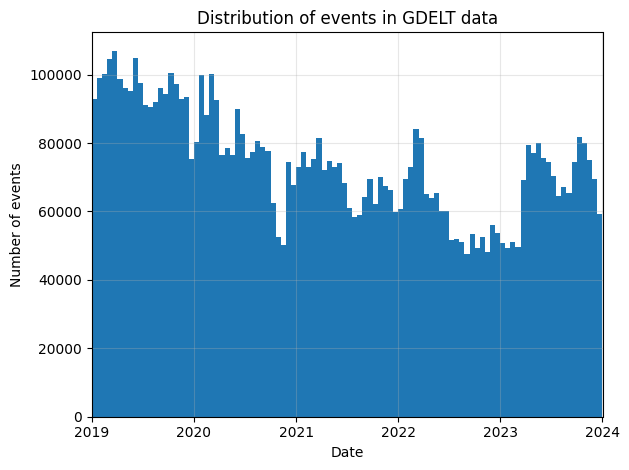

In [ ]:
gdelt.date.hist(bins=100)
plt.xlim([pd.Timestamp('2019-01-01'), pd.Timestamp('2024-01-01')])
plt.grid(True, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Number of events')
plt.title('Distribution of events in GDELT data')